# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [1]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

In [2]:
import pandas as pd
from IPython.display import display
pd.options.display.float_format = '{:,.2f}'.format

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [3]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [4]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [5]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

print(grad_f(1.0, 0.0)) # array([1., 2.])
g = autograd.grad
print(g(f,0)(0.0,0.0))

[0.54030231 2.        ]
1.0


In [6]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [7]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [8]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

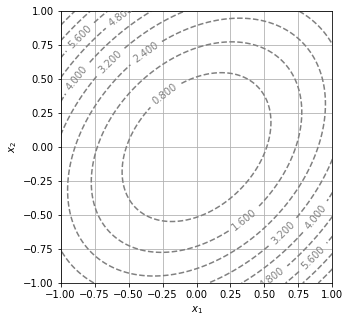

In [9]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [10]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

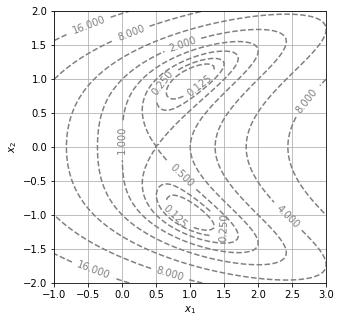

In [11]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [12]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

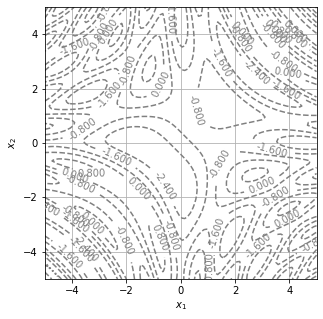

In [13]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [220]:
N = 1000
eps = 10**(-2)

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [221]:
def Newton(F, x0, y0, eps=eps, N=N, debug=False):
    j_f = J(F)
    for i in range(N):
        v = np.array([x0, y0])
        g = j_f(x0,y0)
        # print(x0, y0, F(x0,y0))
        x, y = v - np.dot(
            np.linalg.inv(g),
            F(x0, y0)
        )       
        if debug: 
            plt.scatter(x, y)
            
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
    else:
        raise ValueError(f"no convergence in {N} steps.")

(0.447250250297228, 0.447250250297228)


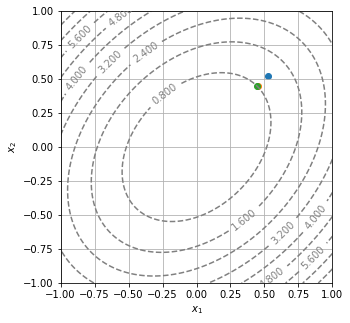

In [222]:
display_contour(
    f1,
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)


def F1(x, y):
    c = 0.8
    return np.array([f1(x, y) - c, x - y])

# print(Newton(F1, -0.8, -0.8))
print(Newton(F1, 0.8, 0.8, debug=True))
# Newton(F1, 0.9, -0.9)

(0.11103236681010874, 0.11103236681010872)


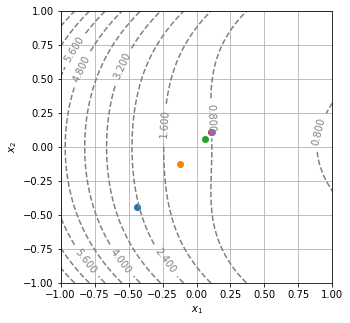

In [223]:
display_contour(
    f2,
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)


def F2(x, y):
    c = 0.8
    return np.array([f2(x, y) - c, x - y])

# print(Newton(F1, -0.8, -0.8))
print(Newton(F2, 0.8, 0.8, debug=True))
# Newton(F1, 0.9, -0.9)

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

- Utiliser comme point de départ: vecteur gradient normé * delta

In [224]:
def to_float(a, precision=2):
    try:
        return round(float(a._value), precision)
    except:
        return round(float(a), precision)

In [225]:
def level_curve(f, x0, y0, delta=.1, N=250, eps=eps, debug=False):
    niveau = np.zeros(shape=(2, N))
    niveau[:, 0] = [x0, y0]
    c = f(x0, y0)
    
    for i in range(1, N):
        g = grad(f)(x0, y0)
        x_g, y_g = g / np.linalg.norm(g)
        x_recherche = x0 + delta * y_g
        y_recherche = y0 + delta * (-x_g)
        # plt.scatter(x_recherche, y_recherche)
        def dist_delta(x, y):
            ps = (x - x0)*y_g + (y - y0)*(-x_g)
            if ps >= 0:
                malus = 0
            else:
                malus = (2*ps)**2
            if debug:
                print(to_float(x), to_float(y), "malus", to_float(malus))
            return np.linalg.norm(np.array([x - x0, y - y0])) - delta + malus
            
        def F(x, y):
            return np.array([f(x, y) - c, dist_delta(x, y)])
        
        if debug:
            print('\n--- new x0,y0: ', x0, y0, x_recherche, y_recherche)
            
        x0, y0 = Newton(F, x_recherche, y_recherche)
        niveau[:, i] = [x0, y0]
    return niveau

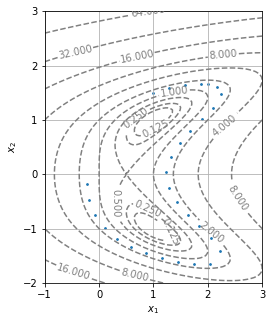

(2, 30)
0 [1.  1.5] 0.30000011044663855 0.0
1 [1.28839998 1.5826167 ] 0.3000001695495457 0.30000011044663855
2 [1.58291558 1.63971891] 0.3000009094725612 0.5994263474147136
3 [1.88195964 1.66366043] 0.3000846600939803 0.8970159087238235
4 [2.17750226 1.61164732] 0.17939804107295054 1.1827834504015113
5 [2.00421799 1.65808245] 0.3000058721129237 1.0165843982226621
6 [2.24934176 1.48511464] 0.3000003153804083 1.2494304302586057
7 [2.0986314  1.22571808] 0.3000000407454749 1.1323522086635498
8 [1.89205295 1.00817413] 0.30000162564663146 1.018651633023403
9 [1.68074579 0.79521812] 0.30000000655106873 0.9798634258195305
10 [1.48068414 0.57166648] 0.300000247462122 1.0453996228608389
11 [1.31385351 0.32233198] 0.30001394359257805 1.2187723263767143
12 [1.22982654 0.03432533] 0.3000000012305031 1.4835843374935054
13 [ 1.28497494 -0.2605622 ] 0.30000325143678575 1.7834769367513084
14 [ 1.43885333 -0.51809548] 0.3000000944278229 2.0652606680243664
15 [ 1.6339049  -0.74603176] 0.3000713546273192

In [226]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 3.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)
res = level_curve(f2, 1., 1.5, delta=.3, N=30)
# delta .3 marche pas


plt.scatter(res[0,:],res[1,:], s=3)
plt.show()

print(res.shape)

for i in range(res.shape[1] - 1):
    print(i, res[:, i], np.linalg.norm(res[:,(i+1)%N] - res[:,i]), np.linalg.norm(res[:,0] - res[:,i]))

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [227]:
def level_curve(f, x0, y0, delta=.1, N=250, eps=eps):
    niveau = np.zeros(shape=(2, N))
    niveau[:, 0] = [x0, y0]
    c = f(x0, y0)
    N_reel = N
    
    for i in range(1, N):
        g = grad(f)(x0, y0)
        x_g, y_g = g / np.linalg.norm(g)
        x_recherche = x0 + delta * y_g
        y_recherche = y0 + delta * (-x_g)
    
        def dist_delta(x, y):
            ps = (x - x0)*y_g + (y - y0)*(-x_g)
            if ps >= 0:
                malus = 0
            else:
                malus = ps**2
            # print(to_float(x), to_float(y), "malus", to_float(malus))
            return np.linalg.norm(np.array([x - x0, y - y0])) - delta
            
        def F(x, y):
            return np.array([f(x, y) - c, dist_delta(x, y)])
                
        x0, y0 = Newton(F, x_recherche, y_recherche)
        niveau[:, i] = [x0, y0]
       
        # si on s'approche trop du premier point, on boucle
        # désavantage: il faut pas que la courbe s'auto-
        if np.linalg.norm(niveau[:, i] - niveau[:, 0]) <= delta:
            N_reel = i + 1
            break
        
    return niveau[:, :N_reel]

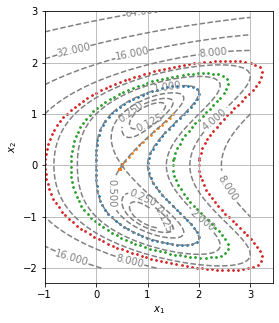

(2, 150)
0 0.10021765558219997 0.0
1 0.10022192076164721 0.10021765558219997
2 0.10019787177129728 0.19999674495730546
3 0.10015695266791186 0.2989253353544318
4 0.10011451811597105 0.3968000151998246
5 0.10007937049400405 0.4936467185150563
6 0.10005348025736903 0.5896412675308154
7 0.1000354897870991 0.6850160979092552
8 0.10002328921682312 0.7799993310333395
9 0.1000150583163775 0.8747878851809696
10 0.10000948107025981 0.9695415606764136
11 0.10000567654821728 1.0643868008156694
12 0.10000308115082968 1.1594237074322002
13 0.10000135529431842 1.254733404598636
14 0.10000033036721381 1.3503847231915669
15 0.10000000284115367 1.4464400282866763
16 0.10000060091807608 1.5429603093322812
17 0.1000028127371139 1.6400096022130668
18 0.10000847941597422 1.7376582743647357
19 0.10002290445840568 1.835982744303899
20 0.10006403850779867 1.9350518695193495
21 0.1002094348678155 2.034859071156452
22 0.10000005915615744 2.1349994631711855
23 0.10000494242486735 2.231919320555883
24 0.100003377

In [228]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 3.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

# delta .3 marche pas
res = level_curve(f2, 0., 0.1, delta=.1)
plt.scatter(res[0,:],res[1,:], s=3)

res = level_curve(f2, 1.5, 1., delta=.1)
plt.scatter(res[0,:],res[1,:], s=3)

res = level_curve(f2, 1.5, 0.1, delta=.1)
plt.scatter(res[0,:],res[1,:], s=3)

res = level_curve(f2, 2., 0.1, delta=.1)
plt.scatter(res[0,:],res[1,:], s=3)

plt.show()

print(res.shape)
for i in range(res.shape[1]):
    print(i, np.linalg.norm(res[:,(i+1)%res.shape[1]] - res[:,i]), np.linalg.norm(res[:,0] - res[:,i]))

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

**Réponse**

Le problème principal réside dans les dimensions du grand carré dans lequel on veut plonger $K$. En effet, selon la forme de la courbe de niveau, l'ensemble de sous-niveau auquel on s'intéresse peut être excentré par rapport à l'origine, constitué d'une réunion d'ensembles disjoints, etc. Le nombre élevé d'éventualités à prendre en compte complique la mise en place d'un algorithme systématique pour trouver la taille du grand carré.

Pour pallier à ce problème, on peut imaginer d'utiliser une approche utilisant la fonction `level_curve`: on utilise tout d'abord `Newton` pour trouver un point de la courbe de niveau associée à $K$, puis on utilise `level_curve` pour discrétiser cette courbe; enfin, on cherche le maximum des abscisses et des ordonnées  en valuer absolue parmi les points. On peut alors tracer le grand carré.

Néanmoins, cette méthode (en plus de rendre la méthode des carrés dépendante de la fonction `level_curve`), ne fonctionnera pas dans tous les cas: si l'ensemble de sous-niveau est composé d'ensembles disjoints, il se peut que l'on ne trouve qu'un des sous-ensembles de l'ensemble, les autres n'étant pas compris dans le carré. Par ailleurs, si la "direction" que l'on donne à la fonction `Newton` pour rechercher un point de l'ensemble ne rencontre pas l'ensemble, la convergence en moins de $N$ étapes de `Newton` n'est pas garantie.

Aussi, deux approches sont possibles: soit on essaye d'appliquer la fonction `taille_grand_carre` au risque de provoquer une erreur, soit on suppose que l'utilisateur a rentré les dimensions du grand carré dans lequel on plonge K. Cela justifie le paramètre optionnel que l'on a ajouté à la fonction `area_squares`.

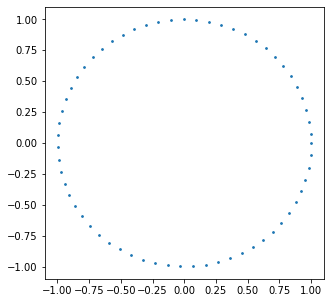

In [229]:
def f_test(x,y):
    return x**2 + y**2

# notre cercle unité
res = level_curve(f_test, 1., 0., delta=.1)
plt.scatter(res[0,:],res[1,:], s=3)
plt.show()

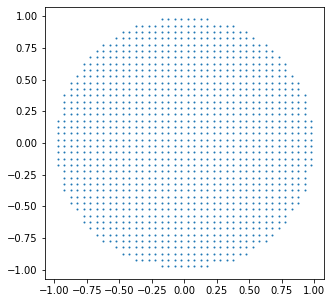

Exemple pour h=0.05, aire: 3.1600000000000006


In [230]:
from itertools import product  # permet de faire le produit cartésien de deux listes


def taille_grand_carre(f, c):
    '''permet de déterminer le côté du carré dans lequel plonger l'ensemble K,
    en prenant le max des abscisse et des ordonnées données par level_curve(),
    après avoir utilisé Newton pour déterminer un point de la ligne de niveau'''
    
    #on part de l'origine
    def F(x,y):
        return np.array([f(x,y) - c, x - y])
    
    x,y = Newton(F, 0.1, 0.1)
    coords = level_curve(f, x, y, delta=.1, N=1000)
    return 1.05 * 2 * np.max(np.abs(coords))  # x1.05 pour ne pas avoir de points sur le bord


def area_squares(f, c, h, cote_carre=0, graphe=False):
    if not cote_carre: 
        # la taille du carré intial n'a pas été renseignée
        # on tente d'appliquer la fonction taille_grand_carre
        cote_carre = taille_grand_carre(f, c) 

    aire = 0
    coords = [
        -cote_carre/2 + (1/2+k)*h 
        for k in range(int(cote_carre/h-1/2)+1)
    ] # création des milieux des carrés
    # on compte le nombre de carrés dont le centre (x, y) est tq f(x, y) <= c
    aire = h**2 * sum(map(lambda a: f(a[0],a[1]) <= c, product(coords, coords)))
    
    
    if graphe: 
        p = np.array(list(filter(lambda a: f(a[0],a[1]) <= c, product(coords, coords))))
        plt.scatter(p[:, 0], p[:, 1], s=1)
        plt.show()
    
    return aire

print("Exemple pour h=0.05, aire:", area_squares(f_test, 1, 0.05, graphe=True))

Reg. linéaire: 0.4804x + -0.0042


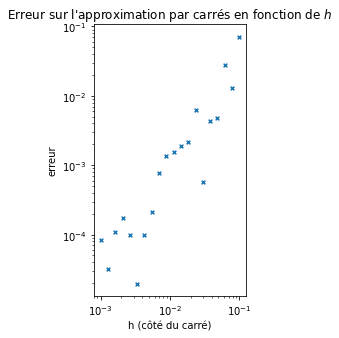

In [231]:
# courbe de l'erreur
values_h = np.geomspace(0.001, 0.1, 20)
ords = [abs(np.pi - area_squares(f_test, 1, h, cote_carre=2.1)) for h in values_h]

m, b = np.polyfit(values_h, ords, 1)
print(f"Reg. linéaire: {round(m, 4)}x + {round(b, 4)}")

plt.title("Erreur sur l'approximation par carrés en fonction de $h$")
plt.xscale('log')
plt.xlabel('h (côté du carré)')
plt.yscale('log')
plt.ylabel('erreur')
plt.scatter(values_h, ords, marker='x', s=14)
plt.axis('scaled')
plt.show()

**Question**  
Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.

**Réponse**

Pour réaliser un encadrement, on utilise le même principe qu'auparavant, en s'intéressant à un point différent: pour minorer l'aire, on vérifie que les quatre coins d'un carré sont contenus dans l'aire pour compter le carré, et pour majorer l'aire on compte tout carré dont au moins un des coins est dans l'aire.

Pour ce faire, on crée une matrice des milieux des carrés,  et l'on compte en itérant sur l'ensemble des coins intérieurs au grand carré le nombre de coins de chaque carré à l'intérieur de l'aire. On ne prend pas en compte les coins "extérieurs", *i.e.* qui n'appartiennent pas à quatre carrés car étant sur le bord du grand carré, ils ne sont pas dans l'aire recherchée.

In [232]:
def area_squares_encadrement(f, c, h, cote_carre=0, graphe=False):
    if not cote_carre: 
        # la taille du carré intial n'a pas été renseignée
        # on tente d'appliquer la fonction taille_grand_carre
        cote_carre = taille_grand_carre(f, c)
    
    nombre_carres_cote = (int(cote_carre/h) + 1)//2 * 2  # c'est plus facile avec un nombre pair
    carres = np.zeros((nombre_carres_cote,nombre_carres_cote))  # chaque carré est identifié par son milieu
    
    for i in range(1, nombre_carres_cote - 1):  # on itère sur les coins intérieurs
        for j in range(1, nombre_carres_cote - 1):
            x = (-nombre_carres_cote//2 + i) * h
            y = (-nombre_carres_cote//2 + j) * h
            if f(x, y) <= c:
                carres[i, j] += 1
                carres[i - 1, j] += 1
                carres[j, i - 1] += 1
                carres[i - 1, j - 1] += 1
    
    # nombre de carrés ayant au moins un coin dans K
    sup = h**2 * np.count_nonzero(carres)
    # nombre de carrés ayant tous leurs coins dans K
    inf = h**2 * np.sum(carres == 4)
    
    return inf, sup, abs(inf - sup)

In [233]:
delta = 0.001

inf, sup, diff = area_squares_encadrement(f_test, 1., delta)
print(f"delta: {delta}, \ninf: {round(inf, 5)}, \n pi: {round(np.pi, 5)}, \nsup: {round(sup, 5)}, \nprécision: {round(diff, 5)}")

delta: 0.001, 
inf: 3.13755, 
 pi: 3.14159, 
sup: 3.14555, 
précision: 0.008


## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

In [234]:
def aire_triangle(p1, p2, p3):
    # sens horaire = aire positive
    return (p3[0]*(p2[1] - p1[1]) + p2[0]*(p1[1] - p3[1]) + p1[0]*(p2[1] - p3[1])) / 2

def aire_BN(f, x0, y0, delt, n, p=(0,0)):
    res = level_curve(f, x0, y0, delta=delt, N=n)
    N = np.shape(res)[1]  # pas forcément égal à n (bouclage)
    aire = 0
    for i in range(N - 1):
        aire += aire_triangle(p, res[:,i], res[:,i + 1])
    
    # ne pas oublier le dernier triangle
    aire += aire_triangle(p, res[:, N-1], res[:, 0])    
    return aire

Reg. linéaire: 0.0448x + -0.0004


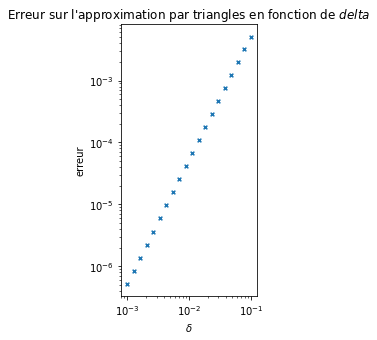

In [235]:
# courbe de l'erreur - pour le disque unité
N_sample = 20

values_delta = np.geomspace(0.001, 0.1, N_sample)
# on écrit le nombre de points requis pour s'assurer un cercle complet
ords = [
    abs(np.pi - aire_BN(f_test, 1., 0., delta, int(np.pi/np.arcsin(delta/2) + 3))) 
    for delta in values_delta
]

m, b = np.polyfit(values_delta, ords, 1)
print(f"Reg. linéaire: {round(m, 4)}x + {round(b, 4)}")


plt.title("Erreur sur l'approximation par triangles en fonction de $delta$")
plt.xscale('log')
plt.xlabel('$\delta$')
plt.yscale('log')
plt.ylabel('erreur')
plt.scatter(values_delta, ords, marker='x', s=14)
plt.axis('scaled')
plt.show()

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

**Réponse**
On rappelle que la formule utilisée pour mesurée l'aire d'un triangle $ABC$, 

$$\text{aire_algebrique}(A, B, C) = \dfrac{x_C(y_B - y_A) + x_B(y_A - y_C) + x_A(y_B - y_C)}{2}$$

donne une aire positive si $A$, $B$, $C$ sont disposés en sens anti-trigonométrique, et l'opposé de cette aire sinon.

1. Si le point est à l'intérieur du cercle, l'aire est simplement la somme des aires (toutes positives) calculées.
2. On se place dans le cas où le point est à l'extérieur de $K$, ou bien à l'intérieur mais que $K$ n'est pas étoilé par rapport au point $p$. Si toutes les aires étaient comptées positivement, l'aire estimée serait trop grande. Cependant, en sommant les $f(A, B, C)$ les aires négatives vont compenser ce surplus et on retrouve la même estimation.

On vérifie que les résultats sont identiques avec $p = (3, -10)$ par exemple:

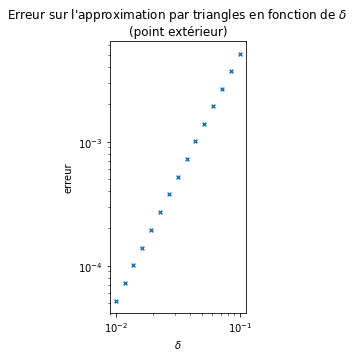

In [236]:
N_sample = 15

values_delta = np.geomspace(0.01, 0.1, N_sample)
# on écrit le nombre de points requis pour s'assurer un cercle complet
ords_decentre = [
    abs(np.pi - aire_BN(f_test, 1., 0., delta, int(np.pi/np.arcsin(delta/2) + 3),
                       p=(3,-10)))  # exemple de point pris à l'extérieur
    for delta in values_delta
]

plt.title("Erreur sur l'approximation par triangles en fonction de $\delta$ \n(point extérieur)")
plt.xscale('log')
plt.xlabel('$\delta$')
plt.yscale('log')
plt.ylabel('erreur')
plt.scatter(values_delta, ords_decentre, marker='x', s=14)
plt.axis('scaled')
plt.show()

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

In [237]:
def un_triangle(p, x, y, i):
    return (x[i+1]*(y[i] - p[1]) + x[i]*(p[0] - y[i+1])) / 2

def area_triangles(x, y):
    # le point p est l'origine du repère.
    p = [0,0]
    aire = 0
    
    # pour compter le dernier triangle
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    
    for i in range(len(x) - 1):
        aire += un_triangle(p, x, y, i)
    return aire

Aire divisée par 2:  3.1415096391149278


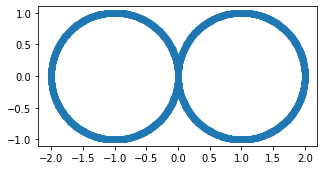

In [241]:
# Union de deux cercles
t1 = np.linspace(0, -2*np.pi, 500)
t2 = np.linspace(np.pi, -np.pi, 500)
gauche = np.array([np.cos(t1) - 1, np.sin(t1)])
droite = np.array([np.cos(t1) + 1, np.sin(t1)])
arr = np.concatenate((gauche, droite), axis=1)

plt.scatter(arr[0], arr[1])
plt.axis('scaled')

print('Aire divisée par 2: ', area_triangles(arr[0], arr[1])/2)

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

**Réponse** On a défini `area_triangles(x, y)` à la question précédente pour pouvoir l'appliquer au cas $K$ non convexe. On va maintenant comparer les deux méthodes, puis fournir des exemples sur des courbes de niveau:

## Comparaison des méthodes

### Théorique

- La méthode des carrés est en $O(n^2)$ où $n$ est le nombre de carrés par côtés (c'est donc en $O(\frac{1}{h^2})$)
- La méthode des triangles est en $O(n)$ où $n$ est le nombre de points sur ce qui est renvoyé par `level_curve`
- L'erreur de la méthode des triangles est calculable facilement (cf. graphique dans la section méthode des triangles), contrairement à celle de la méthode des carrés, au moins dans le cas du cercle unité

### Pratique

- Dans notre implémentation, la méthode des carrés ne mesure pas exactement la même chose: $\{(x, y) \, | \, f(x, y) \leq c\}$ n'est égal à l'intérieur délimité par la courbe de niveau que pour certaines fonctions particulières (cf.exemple 3 au-dessus)

## Exemples

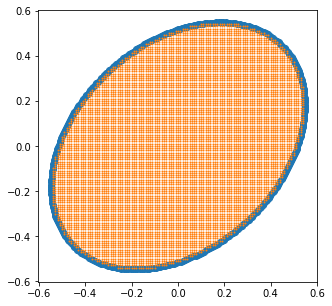

Triangles: 0.8885 Carrés: 0.8875


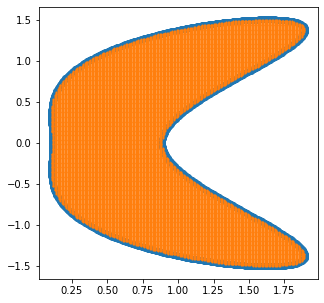

Triangles: 3.0691 Carrés: 3.0712


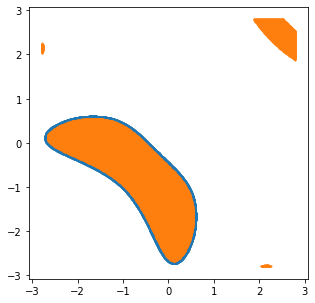

Triangles: 4.0554 Carrés: 4.5115


In [239]:
# permet de prendre f, c en argument (au lieu de x, y)
def area_triangles_function(f, c, delta):
    def F(x, y):
        return np.array([f(x,y) - c, x - y])
    
    x, y = Newton(F, 0.1, 0.1)
    res = level_curve(f, x, y, delta=delta, N=2000)
    
    plt.scatter(res[0,:], res[1,:])
    return area_triangles(res[0,:], res[1,:])


for (f, c) in [(f1, 0.8), (f2, 0.8), (f3, -2.5)]:
    trig = area_triangles_function(f, c, 0.01)
    carr = area_squares(f, c, 0.01, graphe=True)
    print("Triangles:", round(trig, 4), "Carrés:", round(carr, 4))


### Performance en pratique

In [ ]:
# utiliser timeit